![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from collections import Counter
import itertools as it
import re

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [6]:
df_train.rename(columns={'Restaurant_id': 'Restaurant_id', 'City': 'city',
                   'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking', 'Rating': 'Rating'}, inplace=True)

df_train.rename(columns={'Price Range': 'price_range', 'Number of Reviews': 'number_of_reviews',
                   'Reviews': 'reviews', 'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

In [7]:
df_train.columns

Index(['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'Rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta'],
      dtype='object')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
city                 40000 non-null object
cuisine_style        30717 non-null object
ranking              40000 non-null float64
Rating               40000 non-null float64
price_range          26114 non-null object
number_of_reviews    37457 non-null float64
reviews              40000 non-null object
url_ta               40000 non-null object
id_ta                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [9]:
df_test.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [10]:
df_test.rename(columns={'Restaurant_id': 'Restaurant_id', 'City': 'city',
                   'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking'}, inplace=True)

df_test.rename(columns={'Price Range': 'price_range', 'Number of Reviews': 'number_of_reviews',
                   'Reviews': 'reviews', 'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

In [11]:
df_test.columns

Index(['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta'],
      dtype='object')

In [12]:
sample_submission.columns

Index(['Restaurant_id', 'Rating'], dtype='object')

In [13]:
df_train.head(5)

,Restaurant_id,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
city                 10000 non-null object
cuisine_style        7693 non-null object
ranking              10000 non-null float64
price_range          6525 non-null object
number_of_reviews    9343 non-null float64
reviews              9998 non-null object
url_ta               10000 non-null object
id_ta                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [15]:
df_test.head(5)

,Restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [16]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [17]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [18]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [20]:
data.sample(5)

,Restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,Rating
24848,id_5229,Milan,['Italian'],5232.0,NaN,20.0,"[['Decent Pizza near the Duomo', 'A trap for t...",/Restaurant_Review-g187849-d2088264-Reviews-Ri...,d2088264,1,3.0
15806,id_1779,Paris,"['French', 'European']",1780.0,$$ - $$$,432.0,"[['A satisfying, and much anticipated, dining....",/Restaurant_Review-g187147-d718188-Reviews-L_O...,d718188,1,4.0
47272,id_2750,Lisbon,"['Sushi', 'Chinese', 'Japanese']",2753.0,$,28.0,"[['Sushi Buffet', 'Good value for money'], ['0...",/Restaurant_Review-g189158-d6707334-Reviews-Mu...,d6707334,1,3.5
44450,id_21,Budapest,"['Italian', 'Seafood', 'Vegetarian Friendly', ...",22.0,$$ - $$$,249.0,"[['My new favourite', 'Loved it!'], ['01/08/20...",/Restaurant_Review-g274887-d10323830-Reviews-B...,d10323830,1,4.5
6938,id_6938,Zurich,"['Lebanese', 'Mediterranean']",1352.0,NaN,3.0,"[['Most unprofessional restaurant'], ['02/10/2...",/Restaurant_Review-g188113-d11907436-Reviews-H...,d11907436,0,0.0


# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [21]:
data.shape

(50000, 11)

In [22]:
# если есть дублирующие строки,то удаляем, оставив последнее из дублирующихся наблюдений
data.drop_duplicates(keep='last')
# удаляем те строки, в которых все значения являются значениями NaN
data.dropna(how='all')
# попрощаемся со столбцами,  в которых все значения являются значениями NaN
#data.dropna(how='all', axis=1)
# смотрим, сколько было дублирующих строк
data.shape

(50000, 11)

In [23]:
# выводим информацию о количестве пропусков
data.isnull().sum()

Restaurant_id            0
city                     0
cuisine_style        11590
ranking                  0
price_range          17361
number_of_reviews     3200
reviews                  2
url_ta                   0
id_ta                    0
sample                   0
Rating                   0
dtype: int64

In [24]:
# Посмотрим количество пропусков в процентах, так нагляднее
data_null = round(data.isnull().sum() / len(data)*100, 4)
print(data_null)

Restaurant_id         0.000
city                  0.000
cuisine_style        23.180
ranking               0.000
price_range          34.722
number_of_reviews     6.400
reviews               0.004
url_ta                0.000
id_ta                 0.000
sample                0.000
Rating                0.000
dtype: float64


Пропуски в 4 колонках: cuisine_style, price_range, rewiews, number_of_reviews

In [25]:
# Создаем новый признак - счетчик с количеством пропущенных значений по строке
data['missing'] = data.apply(lambda x: x.isnull().sum(), axis='columns')

In [26]:
# обрабатываем столбец с пропусками number_of_reviews, пока заполняю  нулями
data['number_of_reviews_nan'] = pd.isna(data['number_of_reviews']).astype('uint8')
data['number_of_reviews'].fillna(0, inplace=True)

In [27]:
# новый признак с пропусками cuisine_style
data['cuisine_style_nan'] = pd.isna(data['cuisine_style']).astype('uint8')

In [28]:
# новый признак с пропусками price_range 
data['price_range_nan'] = pd.isna(data['price_range']).astype('uint8')

In [29]:
# новый признак с пропусками reviews 
data['rewiews_nan'] = pd.isna(data['reviews']).astype('uint8')

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [30]:
data.nunique(dropna=False)

Restaurant_id            13094
city                        31
cuisine_style            10732
ranking                  12975
price_range                  4
number_of_reviews         1574
reviews                  41858
url_ta                   49963
id_ta                    49963
sample                       2
Rating                      10
missing                      5
number_of_reviews_nan        2
cuisine_style_nan            2
price_range_nan              2
rewiews_nan                  2
dtype: int64

Какие признаки можно считать категориальными?

In [31]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

## ID_TA — идентификатор ресторана в базе данных TripAdvisor;

In [32]:
# посмотрим есть ли повторы 
print("Количество повторов идентификаторов ресторанов в базе данных TripAdvisor", len(data) - data['id_ta'].nunique())

Количество повторов идентификаторов ресторанов в базе данных TripAdvisor 37


In [33]:
# посмотрим на эти записи
dups = data[data.duplicated(subset='id_ta')]
dups

,Restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,Rating,missing,number_of_reviews_nan,cuisine_style_nan,price_range_nan,rewiews_nan
13438,id_1198,Madrid,"['Chinese', 'Japanese', 'Sushi', 'Asian', 'Tha...",1199.0,$$ - $$$,156.0,"[['Excellent cuisine, friendly and helpful se....",/Restaurant_Review-g187514-d2010743-Reviews-Re...,d2010743,1,4.0,0,0,0,0,0
15086,id_2981,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...",2983.0,$$ - $$$,282.0,"[['Very average food. Over average prices.', '...",/Restaurant_Review-g187514-d5618007-Reviews-Ju...,d5618007,1,3.5,0,0,0,0,0
15544,id_1980,Warsaw,"['Mediterranean', 'Middle Eastern', 'Italian',...",1981.0,$$ - $$$,16.0,"[['Good restaurant for one meal.', 'Olive Gard...",/Restaurant_Review-g274856-d3396817-Reviews-Re...,d3396817,1,4.0,0,0,0,0,0
16024,id_3817,Madrid,"['Japanese', 'Peruvian', 'South American', 'Sp...",3819.0,NaN,16.0,"[['Excellent'], ['09/03/2015']]",/Restaurant_Review-g187514-d7827387-Reviews-El...,d7827387,1,5.0,1,0,0,1,0
19446,id_4104,Madrid,['Spanish'],4106.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226,1,5.0,1,0,0,1,0
21330,id_6267,Madrid,NaN,6270.0,NaN,21.0,"[[], []]",/Restaurant_Review-g187514-d5617412-Reviews-Gr...,d5617412,1,3.5,2,0,1,1,0
21583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0,1,0,0,1,0
22628,id_2329,Madrid,NaN,2331.0,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719,1,4.5,2,0,1,1,0
22938,id_2486,Madrid,NaN,2488.0,NaN,10.0,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625,1,5.0,2,0,1,1,0
23576,id_1277,Madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1279.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,1,4.0,0,0,0,0,0


In [34]:
data.id_ta.value_counts().head(40)

d11921719    2
d7809594     2
d7342803     2
d5618007     2
d3748757     2
d9877640     2
d12488993    2
d3647024     2
d7827387     2
d10047799    2
d1568045     2
d2669414     2
d4914988     2
d10440367    2
d4748208     2
d5617412     2
d1235635     2
d7337366     2
d697406      2
d2477531     2
d11999956    2
d13002276    2
d10316215    2
d3396817     2
d2010743     2
d1028622     2
d1315077     2
d2360290     2
d987900      2
d4600226     2
d11698990    2
d8753348     2
d3161682     2
d793170      2
d11674463    2
d9802625     2
d3685055     2
d8278611     1
d3674237     1
d1886510     1
Name: id_ta, dtype: int64

Все рестораны расположены в городе Мадрид и Варшава, повторяются по 2 раза. Выборочно посмотрим на несколько пар, насколко же они разные.

In [35]:
data_temp = data.query('id_ta == "d3396817"')[['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'Rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
data_temp

,Restaurant_id,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta
4323,id_4323,Warsaw,"['Mediterranean', 'Middle Eastern', 'Italian',...",1981.0,0.0,$$ - $$$,16.0,"[['Good restaurant for one meal.', 'Olive Gard...",/Restaurant_Review-g274856-d3396817-Reviews-Re...
15544,id_1980,Warsaw,"['Mediterranean', 'Middle Eastern', 'Italian',...",1981.0,4.0,$$ - $$$,16.0,"[['Good restaurant for one meal.', 'Olive Gard...",/Restaurant_Review-g274856-d3396817-Reviews-Re...


In [36]:
data_temp = data.query('id_ta == "d11698990"')[['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'Rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
data_temp

,Restaurant_id,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta
36431,id_3238,Madrid,NaN,3240.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...
36551,id_3240,Madrid,NaN,3242.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...


In [37]:
data_temp = data.query('id_ta == "d7342803"')[['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'Rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
data_temp

,Restaurant_id,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta
32924,id_2359,Madrid,"['Spanish', 'Mediterranean']",2361.0,4.5,$$ - $$$,16.0,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...
46275,id_2467,Madrid,"['Spanish', 'Mediterranean']",2469.0,4.5,$$ - $$$,16.0,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...


In [38]:
data_temp = data.query('id_ta == "d11921719"')[['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'Rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
data_temp

,Restaurant_id,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta
20819,id_2197,Madrid,NaN,2199.0,4.5,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...
22628,id_2329,Madrid,NaN,2331.0,4.5,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...


In [39]:
data_temp = data.query('id_ta == "d11999956"')[['Restaurant_id', 'city', 'cuisine_style', 'ranking', 'Rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
data_temp

,Restaurant_id,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta
26920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3538.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...
39879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3664.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...


Разный Restaurant_id. Различия не значительные, в основном ухудшение в рейтинге (ranking). Вероятно это все же повторы. Очень хочется удалить, оставив последние из дублирующих.

In [40]:
# нельзя удалять, не совпадает файл на отправку
#data = data.drop_duplicates(subset='id_ta', keep='last')

## Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

Обрабатываем признак, так данные по нему нужны будут для заполнения пропусков в других столбцах.

In [41]:
def norm_Rank(df):
    # найдём для каждого города макс, мини и средний Ranking
    max_rank = df.groupby(['city'])['ranking'].max()
    min_rank = df.groupby(['city'])['ranking'].min()
    mean_rank = df.groupby(['city'])['ranking'].mean()
    std_rank = df.groupby(['city'])['ranking'].std()
    # в каждой строке пропишем соотвествующее значение макс, мини  и среднего Ranking
    df['max_rank'] = df['city'].apply(lambda x: max_rank[x])
    df['min_rank'] = df['city'].apply(lambda x: min_rank[x])
    df['mean_rank'] = df['city'].apply(lambda x: mean_rank[x])
    df['std_city'] = df['city'].apply(lambda x: std_rank[x])
    # minmax нормализация, которая приводит независимо каждый признак к значению между 0 и 1.
    # Для каждого признака мы находим минимальное и максимальное значение,
    # из всех значений вычитаем минимальное значение и делим это на разницу между макс и мини значениями.
    df['rank_min_max'] = (df['ranking'] - df['min_rank']) / \
        (df['max_rank'] - df['min_rank'])
    #  std нормализация из каждого значения в текущем признаке вычитаем среднее значение для всего признака
    # и делим на стандартное отклонение.
    df['rank_std'] = (df['ranking'] - df['mean_rank']) / df['std_city']
    return None

In [42]:
# создаем 2 признака rank_min_max - minmax нормализация, rank_std - std нормализация
norm_Rank(data)

In [43]:
def score(h):
    if h >= 0 and h <= 0.14:
        return 5               # выше Ожидаемого
    if h > 0.14 and h <= 0.59:
        return 4               # превосходно
    if h > 0.59 and h <= 0.78:
        return 3               # удовлетворительно
    if h > 0.78 and h <= 0.92:
        return 2               # слабо
    if h > 0.92:
        return 1               # все плохо

In [44]:
data['place_rank'] = data.rank_min_max.apply(score)

## City — город, в котором находится ресторан

In [45]:
# посмотрим какие города педставлены в наборе данных
city = data.city.unique()
city

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Написаны все по единым правилам, ничего менять не будем.

In [46]:
# количество городов
len(city)

31

In [47]:
# считаем количество ресторанов по городам 
data.city.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

In [48]:
# создаем серию, у которой значениями будут частоты 
# категорий переменной city
city_series = data['city'].value_counts()

In [49]:
# создаем булеву маску, если частота города меньше 0.029,
# будет возвращено значение TRUE, в противном случае
# будет возвращено значение FALSE
mask = (city_series/city_series.sum() * 100).lt(0.029)

# выводим последние 10 городов
mask.tail(10)

Edinburgh     False
Zurich        False
Oporto        False
Geneva        False
Krakow        False
Oslo          False
Helsinki      False
Bratislava    False
Luxembourg    False
Ljubljana     False
Name: city, dtype: bool

Выборка нормальная. Но код обработки выбросов все же пусть будет.

In [50]:
# с помощью функции np.where мы все города, по которым возвращено 
# значение TRUE, заменим на категорию OTHER, в противном случае 
# оставим категории неизменными
data['city'] = np.where(data['city'].isin(city_series[mask].index), 
                                 'OTHER', data['city'])
print(data['city'].value_counts(dropna=False).tail(10))

Edinburgh     745
Zurich        685
Oporto        642
Geneva        590
Krakow        554
Oslo          488
Helsinki      475
Bratislava    380
Luxembourg    263
Ljubljana     222
Name: city, dtype: int64


In [51]:
# cоздаем переменную city_freq, у которой каждое значение - относительная
# частота наблюдений (ресторанов) в категории переменной city
city_freq = data['city'].value_counts() / len(data['city'])
data['city_freq'] = data['city'].map(city_freq)

In [52]:
# cоздаем переменную city_abs_freq, у которой каждое значение - абсолютная
# частота наблюдений (ресторанов) в категории переменной city
abs_freq = data['city'].value_counts()
data['city_abs_freq'] = data['city'].map(abs_freq)

In [53]:
# Создаем новый признак с населением по городам
city_population = {
    'London': 8.9, 'Paris': 2.1, 'Madrid': 3.3,
    'Barcelona': 1.6, 'Berlin': 3.6, 'Milan': 1.4,
    'Rome': 2.9, 'Prague': 1.3, 'Lisbon': 0.5,
    'Vienna': 1.9, 'Amsterdam': 0.9, 'Brussels': 0.2,
    'Hamburg': 1.8, 'Munich': 1.2, 'Lyon': 0.5,
    'Stockholm': 1, 'Budapest': 1.7, 'Warsaw': 1.8,
    'Dublin': 1.2, 'Copenhagen': 0.8, 'Athens': 0.7,
    'Edinburgh': 0.5, 'Zurich': 0.4, 'Oporto': 0.2,
    'Geneva': 0.2, 'Krakow': 0.8, 'Oslo': 0.7,
    'Helsinki': 0.6, 'Bratislava': 0.4, 'Luxembourg': 0.6,
    'Ljubljana': 0.2
}
data['population'] = data['city'].map(city_population)

In [54]:
# Создаем новый признак с рейтингом по развитию сектора туризма в стране
city_country_rating = {
    'London': 5.20, 'Paris': 5.32, 'Madrid': 5.43,
    'Barcelona': 5.43, 'Berlin': 5.28, 'Milan': 4.99,
    'Rome': 4.99, 'Prague': 4.22, 'Lisbon': 4.74,
    'Vienna': 4.86, 'Amsterdam': 4.64, 'Brussels': 4.54,
    'Hamburg': 5.28, 'Munich': 5.28, 'Lyon': 5.32,
    'Stockholm': 4.55, 'Budapest': 4.06, 'Warsaw': 4.11,
    'Dublin': 4.53, 'Copenhagen': 4.43, 'Athens': 4.51,
    'Edinburgh': 5.20, 'Zurich': 4.94, 'Oporto': 4.74,
    'Geneva': 4.94, 'Krakow': 4.11, 'Oslo': 4.64,
    'Helsinki': 4.40, 'Bratislava': 3.90, 'Luxembourg': 4.49,
    'Ljubljana': 4.18
}
data['city_country_rating'] = data['city'].map(city_country_rating)

In [55]:
# Создаем новый признак с количеством туристов по городам
city_tourist = {
    'London': 20.0, 'Paris': 16.1, 'Madrid': 5.5,
    'Barcelona': 6.7, 'Berlin': 5.9, 'Milan': 6.4,
    'Rome': 10.3, 'Prague': 8.9, 'Lisbon': 3.5,
    'Vienna': 6.4, 'Amsterdam': 8.4, 'Brussels': 3.9,
    'Hamburg': 1.5, 'Munich': 4.1, 'Lyon': 6.0,
    'Stockholm': 2.6, 'Budapest': 3.8, 'Warsaw': 2.9,
    'Dublin': 5.2, 'Copenhagen': 3.1, 'Athens': 5.7,
    'Edinburgh': 1.7, 'Zurich': 2.2, 'Oporto': 2.3,
    'Geneva': 1.1, 'Krakow': 2.7, 'Oslo': 1.4,
    'Helsinki': 1.2, 'Bratislava': 0.4, 'Luxembourg': 1.56,
    'Ljubljana': 5.9
}
data['city_tourist'] = data['city'].map(city_tourist)

In [56]:
city_country = {
    'London': 'UK', 'Paris': 'France', 'Madrid': 'Spain',
    'Barcelona': 'Spain', 'Berlin': 'Germany', 'Milan': 'Italy',
    'Rome': 'Italy', 'Prague': 'Czech', 'Lisbon': 'Portugalia',
    'Vienna': 'Austria', 'Amsterdam': 'Nederlands', 'Brussels': 'Belgium',
    'Hamburg': 'Germany', 'Munich': 'Germany', 'Lyon': 'France',
    'Stockholm': 'Sweden', 'Budapest': 'Hungary', 'Warsaw': 'Poland',
    'Dublin': 'Ireland', 'Copenhagen': 'Denmark', 'Athens': 'Greece',
    'Edinburgh': 'Schotland', 'Zurich': 'Switzerland', 'Oporto': 'Portugalia',
    'Geneva': 'Switzerland', 'Krakow': 'Poland', 'Oslo': 'Norway',
    'Helsinki': 'Finland', 'Bratislava': 'Slovakia', 'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}
data['city_country'] = data['city'].map(city_country)

In [57]:
city_geo = {'London': 0, 'Paris': 1, 'Madrid': 2,
        'Barcelona': 2, 'Berlin': 1, 'Milan': 2,
        'Rome': 2, 'Prague': 3, 'Lisbon': 2,
        'Vienna': 1, 'Amsterdam': 1, 'Brussels': 1,
        'Hamburg': 1, 'Munich': 1, 'Lyon': 1,
        'Stockholm': 1, 'Budapest': 3, 'Warsaw': 3,
        'Dublin': 0, 'Copenhagen': 1, 'Athens': 2,
        'Edinburgh': 0, 'Zurich': 2, 'Oporto': 2,
        'Geneva': 2, 'Krakow': 3, 'Oslo': 3, 
        'Helsinki': 3, 'Bratislava': 3, 'Luxembourg': 3,
        'Ljubljana': 3,}
data['city_geo'] = data['city'].map(city_geo)

## Number of Reviews — количество отзывов о ресторане;

Здесь 6,4% (3200) пропусков. 

Number of Reviews - 6,4% (3200) пропусков. 
Количество отзывов о ресторане с низким внутригородским рейтингом видимо накручивается. Идет большее количество по низкому рейтингу, затем спад и нормальный рост. Поэтому пропуски заполним целым средним значением по условному внутригородскому рейтингу.

In [58]:
def fillna_reviews(row):
    if row['number_of_reviews'] == 0:
        return row['reviews_rank_mean']
    else:
        return row['number_of_reviews']

In [59]:
# Создаем новый признак. Среднее количество отзывов по условному рейтингу
data_temp = data.query('number_of_reviews > 0')
reviews_place_mean = round(data_temp.groupby(['place_rank'])['number_of_reviews'].mean(),0)
data['reviews_rank_mean'] = data['place_rank'].apply(lambda x: reviews_place_mean[x])

In [60]:
# заменяем пропуски на среднее количество отзывов по условному рейтингу
new_reviews = data.apply(lambda row: fillna_reviews(row), axis=1)
data['number_of_reviews'] = new_reviews

## Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

Здесь много пропусков - 23,2% (11590). Создадим новый признак количество видов кухни, к которым можно отнести блюда, предлагаемые в ресторане и заполним его.

In [61]:
def parse_list(text):
    return eval(text)

In [62]:
def count_cuis(c_list):
    return len(set(c_list))

In [63]:
data['cuisine_style2'] = data['cuisine_style']

In [64]:
# считаем количество видов кухни в ресторане
data['cuisine_style'] = data.cuisine_style[data.cuisine_style.notna()].apply(parse_list)
data['style_count'] = data.cuisine_style[data.cuisine_style.notna()].apply(count_cuis)
data['cuisine_style'].head(5)

0                                           [Bar, Pub]
1    [European, Scandinavian, Gluten Free Options, ...
2                                [Vegetarian Friendly]
3    [Italian, Mediterranean, European, Vegetarian ...
4    [Italian, Mediterranean, European, Seafood, Ve...
Name: cuisine_style, dtype: object

In [65]:
# посмотрим на количество видов кухни в ресторанах
s = data['style_count'].value_counts() / len(data)*100
display(s)

1.0     18.308
2.0     15.588
3.0     13.276
4.0     11.896
5.0      8.964
6.0      5.222
7.0      2.588
8.0      0.726
9.0      0.186
10.0     0.052
11.0     0.008
15.0     0.002
13.0     0.002
21.0     0.002
Name: style_count, dtype: float64

In [66]:
# Посмотрим на записи, где количество видов кухонь больше десяти
style_count21 = data.query('style_count > 10')[['city', 'cuisine_style', 'ranking', 'Rating',
                                              'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
len(style_count21)

7

In [67]:
display(style_count21)

,city,cuisine_style,ranking,Rating,price_range,number_of_reviews,reviews,url_ta
5510,Copenhagen,"[Mexican, Chinese, Japanese, American, Lebanes...",34.0,0.0,NaN,3426.0,"[['Variety', 'Bustling. Busy and a great time....",/Restaurant_Review-g189541-d6856601-Reviews-Co...
8676,Milan,"[Chinese, Japanese, Sushi, Asian, Thai, Vietna...",302.0,0.0,$$ - $$$,446.0,"[['A modern, trendy take on Asian fusion', 'Av...",/Restaurant_Review-g187849-d1217778-Reviews-Bl...
28820,Milan,"[Chinese, Japanese, Seafood, Sushi, Asian, Tha...",95.0,4.5,$$ - $$$,578.0,"[['Amazing place!', 'Very good food!'], ['11/0...",/Restaurant_Review-g187849-d2189790-Reviews-La...
30452,Ljubljana,"[Japanese, Fast Food, Mediterranean, Barbecue,...",4.0,4.5,$,194.0,"[['A very special event!', 'Great ambiance, gr...",/Restaurant_Review-g274873-d8262021-Reviews-Od...
36651,Berlin,"[Italian, French, German, Seafood, Mediterrane...",32.0,4.5,$$ - $$$,1414.0,[['bouillabaisse for one for €9.95 not worth.....,/Restaurant_Review-g187323-d4005516-Reviews-Ka...
46952,Rome,"[Italian, Lebanese, Moroccan, Mediterranean, E...",1539.0,4.0,$$ - $$$,388.0,"[['Try it!', 'Good attempt at fusion cuisine']...",/Restaurant_Review-g187791-d2397684-Reviews-Me...
49413,Amsterdam,"[Asian, Italian, French, American, Indian, Dut...",94.0,4.5,$$ - $$$,1480.0,"[['Amazing place, great food & vibe - you MUS....",/Restaurant_Review-g188590-d7231902-Reviews-Fo...


Таких записей всего 7. Диапазон цен у всех - дешевые блюда и хороший rating. Вероятно перечислили все знакомые виды кухонь. Уменьшим количество видов кухонь до 10.

In [68]:
# уменьшаем количество видов кухонь до 10
data.loc[(data['style_count'] > 10), 'style_count'] = 10

In [69]:
# eще раз посмотрим на количество видов кухни в ресторанах
s = data['style_count'].value_counts() / len(data)*100
display(s)

1.0     18.308
2.0     15.588
3.0     13.276
4.0     11.896
5.0      8.964
6.0      5.222
7.0      2.588
8.0      0.726
9.0      0.186
10.0     0.066
Name: style_count, dtype: float64

In [70]:
# пока пропуски заполню 0
data['style_count'].fillna(0, inplace=True)

In [71]:
def fillna_style(row):
    if row['style_count'] == 0:
        return row['med_style']
    else:
        return row['style_count']

In [72]:
# пропуски заполню медианной  по городу
data_style = data.query('style_count > 0')
med_style = data_style.groupby(['city'])['style_count'].median()
data['med_style'] = data['city'].apply(lambda x: med_style[x])
data['med_style'] = round(data['med_style'],0)
# заменим пропуски
new_style = data.apply(lambda row: fillna_style(row), axis=1)
data['style_count'] = new_style

In [73]:
# eще раз посмотрим на относительное количество видов кухни в ресторанах 
s = data['style_count'].value_counts() / len(data)*100
display(s)

3.0     27.604
2.0     22.360
1.0     18.308
4.0     13.976
5.0      8.964
6.0      5.222
7.0      2.588
8.0      0.726
9.0      0.186
10.0     0.066
Name: style_count, dtype: float64

In [74]:
# посмотрим, сколько всего стилей кухни встречается датасете
cuisine_styles2 = Counter()
for i in data['cuisine_style2'].dropna():
    l = re.sub('\s\'|\'', '', i)[1:-1].split(',')
    cuisine_styles2.update(l)

cuisines2 = [x[0] for x in cuisine_styles2.most_common()]
len(cuisines2)

125

In [75]:
cuisine_styles2.most_common()

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727),
 ('American', 1642),
 ('Sushi', 1450),
 ('Chinese', 1446),
 ('Portuguese', 1385),
 ('Indian', 1328),
 ('Middle Eastern', 980),
 ('Thai', 923),
 ('Wine Bar', 877),
 ('German', 820),
 ('Halal', 773),
 ('Greek', 768),
 ('Healthy', 758),
 ('Fusion', 748),
 ('Czech', 745),
 ('Steakhouse', 729),
 ('Barbecue', 710),
 ('Contemporary', 652),
 ('Soups', 630),
 ('Eastern European', 629),
 ('Vietnamese', 622),
 ('Grill', 617),
 ('Gastropub', 608),
 ('Turkish', 574),
 ('Mexican', 572),
 ('South American', 490),
 ('Delicatessen', 473),
 ('Austrian', 462),
 ('Polish', 453),
 ('Scandinavi

In [76]:
cuisine_most_common = [x[0] for x in cuisine_styles2.most_common()[:10]]
cuisine_most_common

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza']

In [77]:
# превратим Cuisine Style в список
cuisine_style2 = data['cuisine_style2'].apply(lambda x: ['other_style'] if pd.isnull(x) else x[1:-1].split(',') )
cuisine_style2.sample(5)

14482                          ['European',  'Portuguese']
3897                                         [other_style]
42990                                 ['Indian',  'Asian']
22605    ['Italian',  'Pizza',  'Mediterranean',  'Vege...
48169                                          ['Italian']
Name: cuisine_style2, dtype: object

In [78]:
# Изменим столбец Cuisine Style так: если стиль кухни ресторана 
# попадает в самые частые значения, то оставляем его, если нет, меняем на other_style
for i,k in enumerate(cuisine_style2):
    new_list = []
    for j in k:
        j = re.sub('\s\'|\'','', j)
        if j in cuisine_most_common:
            new_list.append(j)
        else:
            new_list.append('other_style')
    cuisine_style2.at[i] = new_list
cuisine_style2.sample(5)

4926                               [French, Bar, European]
19224                                        [other_style]
31766    [Italian, other_style, Mediterranean, Gluten F...
19756    [other_style, European, Bar, Vegetarian Friendly]
32544                                        [other_style]
Name: cuisine_style2, dtype: object

In [79]:
# Теперь добавим новые признаки, соответсвующие самым частым значениям стилей кухонь
cuisine_style_new = pd.DataFrame(cuisine_style2)
for i in cuisine_most_common + ['other_style']:
    cuisine_style_new[i] = cuisine_style2.apply(lambda x: 1 if i in x else 0).astype('uint8')

cuisine_style_new.drop('cuisine_style2', axis = 1, inplace=True)
cuisine_style_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Vegetarian Friendly    50000 non-null uint8
European               50000 non-null uint8
Mediterranean          50000 non-null uint8
Italian                50000 non-null uint8
Vegan Options          50000 non-null uint8
Gluten Free Options    50000 non-null uint8
Bar                    50000 non-null uint8
French                 50000 non-null uint8
Asian                  50000 non-null uint8
Pizza                  50000 non-null uint8
other_style            50000 non-null uint8
dtypes: uint8(11)
memory usage: 537.2 KB


In [80]:
data = pd.concat([data, cuisine_style_new], sort=False, axis=1)

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
Restaurant_id            50000 non-null object
city                     50000 non-null object
cuisine_style            38410 non-null object
ranking                  50000 non-null float64
price_range              32639 non-null object
number_of_reviews        50000 non-null float64
reviews                  49998 non-null object
url_ta                   50000 non-null object
id_ta                    50000 non-null object
sample                   50000 non-null int64
Rating                   50000 non-null float64
missing                  50000 non-null int64
number_of_reviews_nan    50000 non-null uint8
cuisine_style_nan        50000 non-null uint8
price_range_nan          50000 non-null uint8
rewiews_nan              50000 non-null uint8
max_rank                 50000 non-null float64
min_rank                 50000 non-null float64
mean_rank                50000 non-null float6

In [82]:
data['cuisine_style2'].fillna('other_style', inplace = True)
data['cuisine_style2'].sample(5)

27808    ['Spanish']
23811      ['Pizza']
1877     other_style
240        ['Pizza']
26726     ['French']
Name: cuisine_style2, dtype: object

## Price Range — диапазон цен в ресторане;

Здесь много пропусков 34.7% (17361).

Столбец price_range содержит в себе ценовой диапазон блюд, предлагаемых в ресторане.

Всего возможно три варианта значений:
'S' - дешёвые блюда (16%),
'SS - SSS' - блюда средней ценовой категории (46%),
'SSSS' - дорогие блюда (4%).

In [83]:
data['price_range'].value_counts(dropna = False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [84]:
# диапазон цен в ресторане: 1, 2, 3. пропуски заменим на 2
def price_range_n(df):
    df['price_range'].fillna(2, inplace=True)
    df['price_range'].replace(
        ['$', '$$ - $$$', '$$$$'], [1, 2, 3], inplace=True)
    return df['price_range']

In [85]:
def fillna_price(row):
    if row['price_range'] == 0:
        if (row['number_of_reviews'] > row['reviews_rank_mean']) and (row['place_rank'] == 5) and (row['style_count'] < 3):
            return 1
        elif (row['number_of_reviews'] > row['reviews_rank_mean']) and (row['place_rank'] == 5) and (row['style_count'] > 3):
            return 3
        else:
            return 2                                                            
    else:
        return row['price_range']

In [86]:
data['price_range'] = price_range_n(data)

In [87]:
# заменим пропуски, но выяснилось что лучший результат, когда замена просто 0
#new_price = data.apply(lambda row: fillna_price(row), axis=1)
#data['price_range'] = new_price

## Restaurant_id — идентификационный номер ресторана / сети ресторанов;

In [88]:
# посмотрим есть ли повторы 
print("Количество повторов идентификационный номер ресторана / сети ресторанов", len(data) - data['Restaurant_id'].nunique())

Количество повторов идентификационный номер ресторана / сети ресторанов 36906


In [89]:
data.Restaurant_id.value_counts().head(10)

id_871    19
id_633    19
id_436    19
id_227    19
id_71     18
id_534    18
id_344    18
id_430    18
id_321    18
id_585    18
Name: Restaurant_id, dtype: int64

In [90]:
# посмотрим есть ли повторы 
print("Количество повторов идентификационный номер ресторана / сети ресторанов", len(df_test) - df_test['Restaurant_id'].nunique())

Количество повторов идентификационный номер ресторана / сети ресторанов 0


In [91]:
df_temp = data.query('Restaurant_id == "id_436"')[['Restaurant_id', 'city', 'cuisine_style', 'style_count', 'ranking', 'Rating', 'place_rank', 
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
df_temp

,Restaurant_id,city,cuisine_style,style_count,ranking,Rating,place_rank,price_range,number_of_reviews,reviews,url_ta
436,id_436,Lisbon,"[European, Portuguese]",2.0,2904.0,0.0,2,2,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...
12955,id_436,Barcelona,"[Seafood, Mediterranean, Spanish, Gluten Free ...",4.0,437.0,4.5,5,2,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...
14674,id_436,Copenhagen,"[European, Spanish, Mediterranean, Vegetarian ...",4.0,437.0,4.0,4,2,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...
16118,id_436,Oporto,"[European, Portuguese, Soups, Cafe, Vegetarian...",6.0,437.0,4.5,4,1,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...
16215,id_436,Budapest,"[American, Vegetarian Friendly, Vegan Options]",3.0,437.0,4.5,4,1,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...
17377,id_436,Luxembourg,[Asian],1.0,437.0,4.5,3,2,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...
18168,id_436,Oslo,"[European, Scandinavian]",2.0,437.0,4.0,4,3,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...
18497,id_436,Milan,"[Italian, Pizza, Mediterranean, Vegetarian Fri...",5.0,437.0,4.0,5,2,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...
22554,id_436,Ljubljana,NaN,4.0,437.0,3.0,1,2,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...
23313,id_436,Krakow,[Vegetarian Friendly],1.0,437.0,4.5,4,2,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...


In [92]:
df_temp = data.query('Restaurant_id == "id_1356"')[['city', 'cuisine_style', 'style_count', 'ranking', 'Rating', 'place_rank',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
df_temp

,city,cuisine_style,style_count,ranking,Rating,place_rank,price_range,number_of_reviews,reviews,url_ta
1356,Bratislava,NaN,3.0,695.0,0.0,2,2,8.0,"[['Positive surprise', 'Terrible, terrible cus...",/Restaurant_Review-g274924-d10810542-Reviews-T...
12762,Lyon,NaN,2.0,1357.0,4.5,4,2,19.0,"[[], []]",/Restaurant_Review-g1080938-d1332788-Reviews-M...
22491,Lisbon,"[European, Portuguese]",2.0,1357.0,5.0,4,2,10.0,"[['Very friendly', 'Reasonable price and amazi...",/Restaurant_Review-g189158-d12281887-Reviews-O...
24708,Milan,NaN,3.0,1358.0,4.0,4,2,50.0,"[[], []]",/Restaurant_Review-g187849-d10832843-Reviews-K...
43867,Oporto,NaN,3.0,1357.0,3.5,2,2,3.0,"[['Take Away and snacks'], ['10/08/2017']]",/Restaurant_Review-g189180-d10717036-Reviews-N...


In [93]:
df_temp = data.query('Restaurant_id == "id_585"')[['city', 'cuisine_style', 'style_count', 'ranking', 'Rating', 'place_rank',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta']]
df_temp

,city,cuisine_style,style_count,ranking,Rating,place_rank,price_range,number_of_reviews,reviews,url_ta
585,Paris,NaN,2.0,10563.0,0.0,3,2,5.0,"[[], []]",/Restaurant_Review-g187147-d12411515-Reviews-P...
12887,Amsterdam,"[American, Bar, Pub, Barbecue]",4.0,586.0,4.0,4,2,116.0,[['Great wings and ribs - but not your usual.....,/Restaurant_Review-g188590-d7799470-Reviews-Sm...
15557,Lyon,"[French, Bar, European, Vegetarian Friendly]",4.0,586.0,4.0,4,2,268.0,"[['Nice lunch', 'Great value menu and very tas...",/Restaurant_Review-g187265-d4093687-Reviews-Le...
15893,Oslo,[Vietnamese],1.0,586.0,4.0,4,2,16.0,[['Intimate restaurant with excellent food (l....,/Restaurant_Review-g190479-d8707508-Reviews-Oe...
19084,Munich,"[Italian, Pizza, Mediterranean, European, Vege...",5.0,591.0,4.0,4,2,78.0,"[['Lovely italian', 'Terrific food, authentic ...",/Restaurant_Review-g187309-d2043121-Reviews-Il...
23168,Edinburgh,"[Bar, Pizza, British, Vegetarian Friendly, Glu...",5.0,586.0,4.0,4,2,306.0,"[['Buckstone Regulars Christmas Lunch', 'Very ...",/Restaurant_Review-g186525-d1127301-Reviews-Ch...
25868,Stockholm,"[Seafood, Swedish]",2.0,586.0,4.0,4,3,85.0,"[['Very disappointed...', 'Great place!'], ['1...",/Restaurant_Review-g189852-d2072805-Reviews-Oy...
29493,London,"[Italian, Mediterranean, European, Vegetarian ...",6.0,586.0,4.0,5,2,820.0,"[['DINNER', 'Good decent food.'], ['12/13/2017...",/Restaurant_Review-g186338-d1389702-Reviews-Ol...
30131,Vienna,NaN,3.0,586.0,5.0,4,2,30.0,"[['Unique experience', 'All inclusive experien...",/Restaurant_Review-g190454-d1857535-Reviews-Vi...
30311,Warsaw,"[Chinese, Asian, Vegetarian Friendly]",3.0,586.0,4.0,4,3,24.0,"[['A chinese feast', 'High End Spicy Chinese']...",/Restaurant_Review-g274856-d12187950-Reviews-P...


Все очень странно. У всех ресторанов с одинаковым Restaurant_id кроме одной записи одинаковый ranking - место, которое занимает данный ресторан среди всех ресторанов своего города. А города то разные. Заходила на сайт и чисто внеше это рестораны не принадлежат одной сети. Что с этой находкой делать я пока не знаю. ID ресторана очень похож рейтинг -1. Если бы в тесте были повторы, то создала бы новые признаки с рейтингом.

In [94]:
# Создаем новый признак. 
#restaurant_price_max = data.groupby(['Restaurant_id'])['price_range'].max()
#data['restaurant_price_max'] = data['Restaurant_id'].apply(lambda x: restaurant_price_max[x])
#restaurant_rank = data.groupby(['Restaurant_id'])['ranking'].min()
#data['restaurant_rank'] = data['Restaurant_id'].apply(lambda x: restaurant_rank[x])
#restaurant_number = data.groupby(['Restaurant_id'])['number_of_reviews'].max()
#data['restaurant_number'] = data['Restaurant_id'].apply(lambda x: restaurant_number[x])
#restaurant_counts = data.Restaurant_id.value_counts()
#data['restaurant_counts'] = data['Restaurant_id'].apply(lambda x: restaurant_counts[x])

In [95]:
# Создаем новый признак. 
#data['restaurant_rank_price'] = data['restaurant_price_max'] * data['place_rank']
#data['restaurant_rank_style'] = data['restaurant_price_max'] * data['style_count'] * data['city_freq']
#data['price_reviews_count'] = data['number_of_reviews'] * data['price_range'] * data['restaurant_rank']

## Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

In [96]:
# посмотрим как выглядит признак
data['reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [97]:
# количество пропусков
pd.isna(data['reviews']).sum()

2

In [98]:
# заменим пропуски
data['reviews'] = data['reviews'].apply(
    lambda x: None if x == '[[], []]' else x)
# сперва выпишем ревью отдельно
data['review_1'] = data['reviews'].str.findall(r"'([\w\s]*)'").str[0]
data['review_2'] = data['reviews'].str.findall(r"'([\w\s]*)'").str[1]

In [99]:
# теперь поработаем с датами
data['date_1'] = data['reviews'].str.findall(r"'([\d\/]*)'").str[0]
data['date_2'] = data['reviews'].str.findall(r"'([\d\/]*)'").str[1]

In [100]:
# замена пропусков
data.loc[(data.date_1.str.len() < 10) | (data.date_1.isna()), 'date_1'] = None
data.loc[(data.date_2.str.len() < 10) | (data.date_2.isna()), 'date_2'] = None
data.date_1 = pd.to_datetime(data.date_1)
data.date_2 = pd.to_datetime(data.date_2)

In [101]:
# создание новых признаков
data['new_year'] = ((data.date_1.dt.month_name().isin(['December', 'January'])) | (
    data.date_2.dt.month_name().isin(['December', 'January']))).astype(int)
data['year_1'] = data.date_1.dt.year
data['year_2'] = data.date_2.dt.year
data['date_days'] = abs(data.date_1 - data.date_2).dt.days

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
Restaurant_id            50000 non-null object
city                     50000 non-null object
cuisine_style            38410 non-null object
ranking                  50000 non-null float64
price_range              50000 non-null int64
number_of_reviews        50000 non-null float64
reviews                  41886 non-null object
url_ta                   50000 non-null object
id_ta                    50000 non-null object
sample                   50000 non-null int64
Rating                   50000 non-null float64
missing                  50000 non-null int64
number_of_reviews_nan    50000 non-null uint8
cuisine_style_nan        50000 non-null uint8
price_range_nan          50000 non-null uint8
rewiews_nan              50000 non-null uint8
max_rank                 50000 non-null float64
min_rank                 50000 non-null float64
mean_rank                50000 non-null float64

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

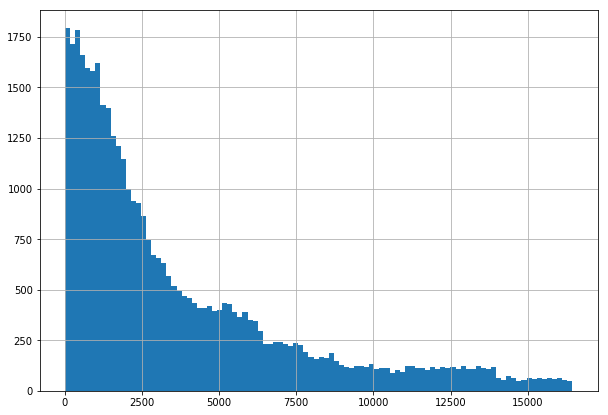

In [103]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

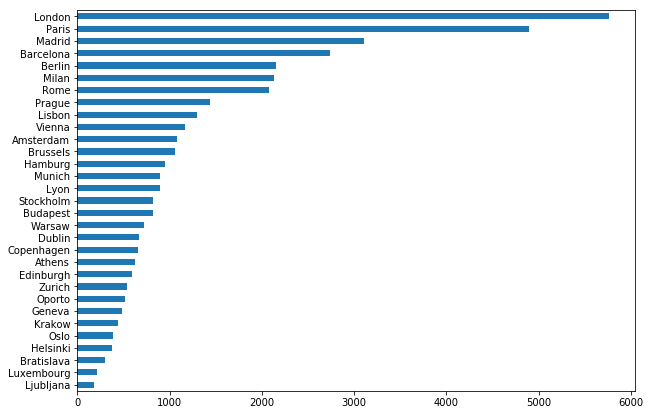

In [104]:
df_train['city'].value_counts(ascending=True).plot(kind='barh')


А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

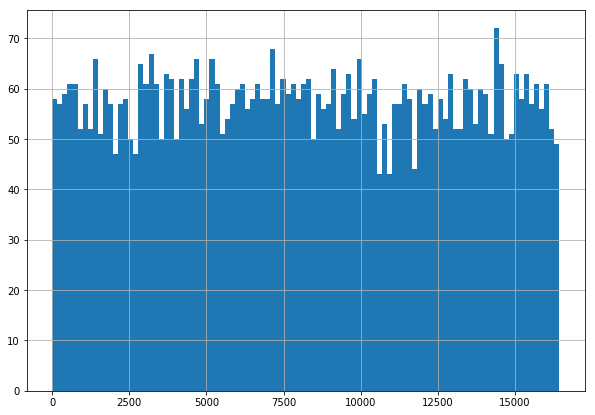

In [105]:
df_train['ranking'][df_train['city'] =='London'].hist(bins=100)

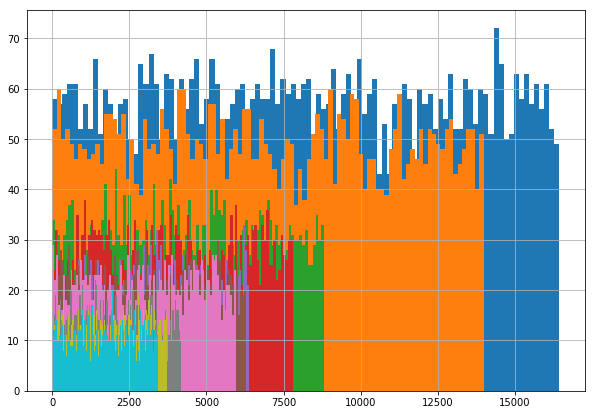

In [106]:
# посмотрим на топ 10 городов
for x in (df_train['city'].value_counts())[0:10].index:
    df_train['ranking'][df_train['city'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

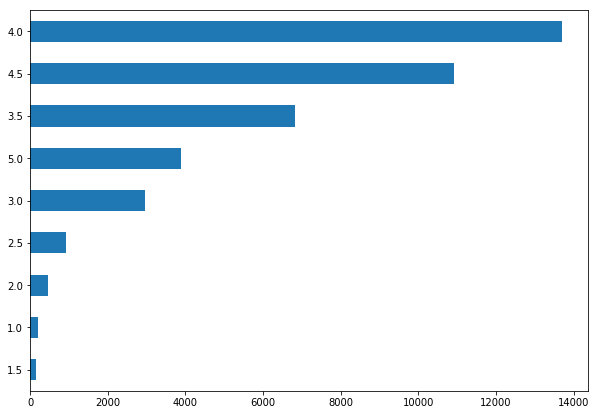

In [107]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

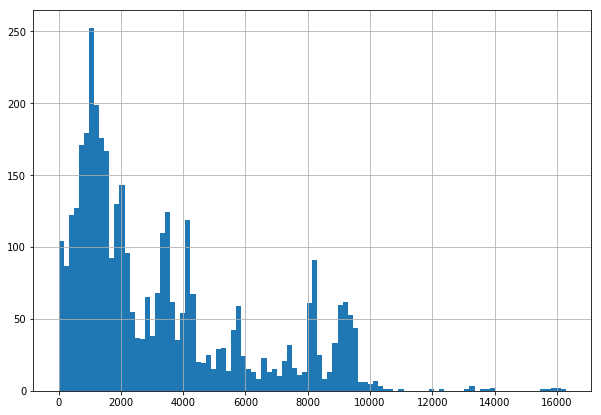

In [108]:
df_train['ranking'][df_train['Rating'] == 5].hist(bins=100)

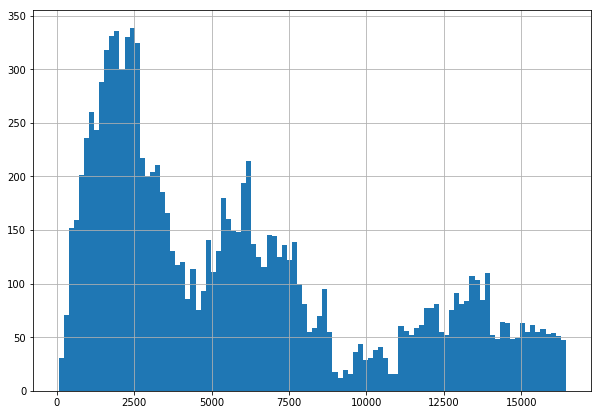

In [109]:
df_train['ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [110]:
#df_train['price_range'].corr(df_train['Rating'])

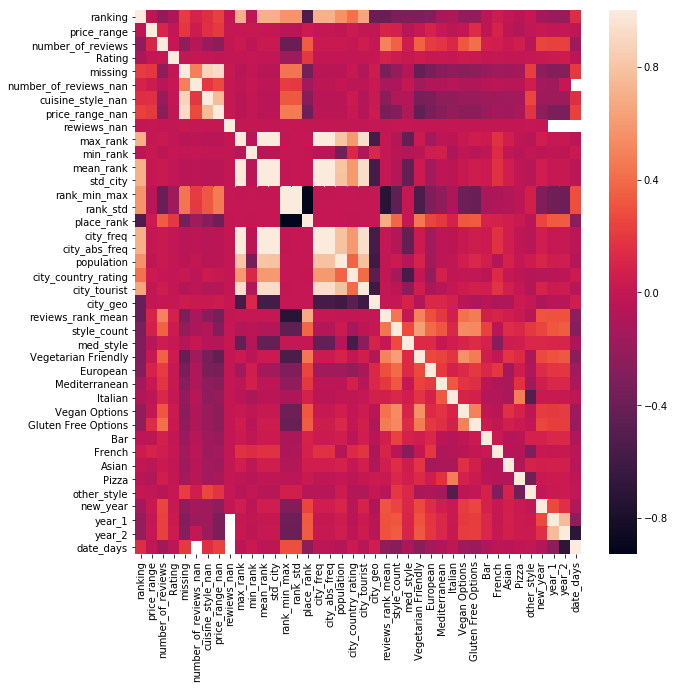

In [111]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [112]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train.rename(columns={'Restaurant_id': 'Restaurant_id', 'City': 'city',
                   'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking', 'Rating': 'Rating'}, inplace=True)

df_train.rename(columns={'Price Range': 'price_range', 'Number of Reviews': 'number_of_reviews',
                   'Reviews': 'reviews', 'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)
df_test.rename(columns={'Restaurant_id': 'Restaurant_id', 'City': 'city',
                   'Cuisine Style': 'cuisine_style', 'Ranking': 'ranking'}, inplace=True)

df_test.rename(columns={'Price Range': 'price_range', 'Number of Reviews': 'number_of_reviews',
                   'Reviews': 'reviews', 'URL_TA': 'url_ta', 'ID_TA': 'id_ta'}, inplace=True)

In [113]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [114]:
def score(h):
    if h >= 0 and h <= 0.14:
        return 5               # выше Ожидаемого
    if h > 0.14 and h <= 0.59:
        return 4               # превосходно
    if h > 0.59 and h <= 0.78:
        return 3               # удовлетворительно
    if h > 0.78 and h <= 0.92:
        return 2               # слабо
    if h > 0.92:
        return 1               # все плохо

def parse_list(text):
    return eval(text)


def count_cuis(c_list):
    return len(set(c_list))


def fillna_style(row):
    if row['style_count'] == 0:
        return row['med_style']
    else:
        return row['style_count']

# диапазон цен в ресторане: 1, 2, 3.
# пропуски заменим на 2


def price_range_n(df):
    df['price_range'].fillna(0, inplace=True)
    df['price_range'].replace(
        ['$', '$$ - $$$', '$$$$'], [1, 2, 3], inplace=True)
    return df['price_range']


def fillna_price(row):
    if row['price_range'] == 0:
        if (row['place_rank'] == 5) and (row['style_count'] == 1) or (row['place_rank'] == 1) and (row['style_count'] == 1):
            return 1
        elif (row['place_rank'] == 5) and (row['style_count'] > 3):
            return 3
        else:
            return 2                                                            
    else:
        return row['price_range']


def reviews_year1(row):
    if row['year_1'] == 0:
        return row['year_2']
    else:
        return row['year_1']

    
def fillna_reviews(row):
    if row['number_of_reviews'] == 0:
        #return row['reviews_rank_mean']
        return row['reviews_city_med']
    else:
        return row['number_of_reviews']

In [115]:
def preproc_data(df_input):
 
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # если есть дублирующие строки,то удаляем, оставив последнее из дублирующихся наблюдений
    df_output.drop_duplicates(keep='last')
    # удаляем те строки, в которых все значения являются значениями NaN
    df_output.dropna(how='all')
    # Создаем новый признак - счетчик с количеством пропущенных значений по строке
    df_output['missing'] = df_output.apply(lambda x: x.isnull().sum(), axis='columns')
    # обрабатываем столбец с пропусками number_of_reviews, пока заполняю  нулями
    df_output['number_of_reviews_nan'] = pd.isna(df_output['number_of_reviews']).astype('uint8')
    df_output['number_of_reviews'].fillna(0, inplace=True)
    # новый признак с пропусками cuisine_style_nan
    df_output['cuisine_style_nan'] = pd.isna(df_output['cuisine_style']).astype('uint8')
    # новый признак с пропусками price_range_nan 
    df_output['price_range_nan'] = pd.isna(df_output['price_range']).astype('uint8')
    # новый признак с пропусками rewiews_nan
    df_output['rewiews_nan'] = pd.isna(df_output['reviews']).astype('uint8')
    #------------------------------------------------------------------------------------------------
    #--- ID_TA — идентификатор ресторана в базе данных TripAdvisor;
    # Удалим дубликаты, оставляю последний
    # df_output = df_output.drop_duplicates(subset='id_ta', keep='last')
    # Убираем переменую 
    df_output = df_output.drop(['id_ta'], axis=1)
    
    #------------------------------------------------------------------------------------------
    #--- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
    # создаем 2 признака rank_min_max - minmax нормализация, rank_std - std нормализация
    # найдём для каждого города макс, мини и средний Ranking
    max_rank = df_output.groupby(['city'])['ranking'].max()
    min_rank = df_output.groupby(['city'])['ranking'].min()
    mean_rank = df_output.groupby(['city'])['ranking'].mean()
    std_rank = df_output.groupby(['city'])['ranking'].std()
    # в каждой строке пропишем соотвествующее значение макс, мини  и среднего Ranking
    df_output['max_rank'] = df_output['city'].apply(lambda x: max_rank[x])
    df_output['min_rank'] = df_output['city'].apply(lambda x: min_rank[x])
    df_output['mean_rank'] = df_output['city'].apply(lambda x: mean_rank[x])
    df_output['std_city'] = df_output['city'].apply(lambda x: std_rank[x])
    # minmax нормализация, которая приводит независимо каждый признак к значению между 0 и 1.
    # Для каждого признака мы находим минимальное и максимальное значение,
    # из всех значений вычитаем минимальное значение и делим это на разницу между макс и мини значениями.
    df_output['rank_min_max'] = (df_output['ranking'] - df_output['min_rank']) / \
        (df_output['max_rank'] - df_output['min_rank'])
    #  std нормализация из каждого значения в текущем признаке вычитаем среднее значение для всего признака
    # и делим на стандартное отклонение.
    df_output['rank_std'] = (df_output['ranking'] - df_output['mean_rank']) / df_output['std_city']
    # новый признак
    df_output['place_rank'] = df_output.rank_min_max.apply(score)
    
    #-----------------------------------------------------------------------------------------------
    #--- Number of Reviews — количество отзывов о ресторане;
    # Создаем новый признак. Среднее количество отзывов по условному рейтингу
    
    data_temp = df_output.query('number_of_reviews > 0')
    reviews_city_med = data_temp.groupby(['city'])['number_of_reviews'].median()
    df_output['reviews_city_med'] = df_output['city'].apply(lambda x: reviews_city_med[x])
        
    # заменяем пропуски на среднее количество отзывов по городу
    new_reviews = df_output.apply(lambda row: fillna_reviews(row), axis=1)
    df_output['number_of_reviews'] = new_reviews
       
    #---------------------------------------------------------------------------------------------
    #--- City — город, в котором находится ресторан
    # создаем серию, у которой значениями будут частоты 
    # категорий переменной city
    city_series =  df_output['city'].value_counts()
    # создаем булеву маску, если частота города меньше 0.029,
    # будет возвращено значение TRUE, в противном случае
    # будет возвращено значение FALSE
    mask = (city_series/city_series.sum() * 100).lt(0.029)
    # с помощью функции np.where все города, по которым возвращено 
    # значение TRUE, заменим на категорию OTHER, в противном случае 
    # оставим категории неизменными
    df_output['city'] = np.where(df_output['city'].isin(city_series[mask].index), 
                                 'OTHER', df_output['city'])
    # cоздаем переменную city_abs_freq, у которой каждое значение - абсолютная
    # частота наблюдений (ресторанов) в категории переменной city
    abs_freq = df_output['city'].value_counts()
    df_output['city_abs_freq'] = df_output['city'].map(abs_freq)  
    # cоздаем переменную city_freq, у которой каждое значение - относительная
    # частота наблюдений (ресторанов) в категории переменной city
    city_freq = df_output['city'].value_counts() / len(df_output['city'])
    df_output['city_freq'] = df_output['city'].map(city_freq)
    city_population = {
        'London': 8.9, 'Paris': 2.1, 'Madrid': 3.3,
        'Barcelona': 1.6, 'Berlin': 3.6, 'Milan': 1.4,
        'Rome': 2.9, 'Prague': 1.3, 'Lisbon': 0.5,
        'Vienna': 1.9, 'Amsterdam': 0.9, 'Brussels': 0.2,
        'Hamburg': 1.8, 'Munich': 1.2, 'Lyon': 0.5,
        'Stockholm': 1, 'Budapest': 1.7, 'Warsaw': 1.8,
        'Dublin': 1.2, 'Copenhagen': 0.8, 'Athens': 0.7,
        'Edinburgh': 0.5, 'Zurich': 0.4, 'Oporto': 0.2,
        'Geneva': 0.2, 'Krakow': 0.8, 'Oslo': 0.7,
        'Helsinki': 0.6, 'Bratislava': 0.4, 'Luxembourg': 0.6,
        'Ljubljana': 0.2
    }
    df_output['population'] = df_output['city'].map(city_population)
    city_tourist = {
        'London': 20.0, 'Paris': 16.1, 'Madrid': 5.5,
        'Barcelona': 6.7, 'Berlin': 5.9, 'Milan': 6.4,
        'Rome': 10.3, 'Prague': 8.9, 'Lisbon': 3.5,
        'Vienna': 6.4, 'Amsterdam': 8.4, 'Brussels': 3.9,
        'Hamburg': 1.5, 'Munich': 4.1, 'Lyon': 6.0,
        'Stockholm': 2.6, 'Budapest': 3.8, 'Warsaw': 2.9,
        'Dublin': 5.2, 'Copenhagen': 3.1, 'Athens': 5.7,
        'Edinburgh': 1.7, 'Zurich': 2.2, 'Oporto': 2.3,
        'Geneva': 1.1, 'Krakow': 2.7, 'Oslo': 1.4,
        'Helsinki': 1.2, 'Bratislava': 0.4, 'Luxembourg': 1.56,
        'Ljubljana': 5.9
    }
    df_output['city_tourist'] = df_output['city'].map(city_tourist)
    
    city_geo = {'London': 0, 'Paris': 1, 'Madrid': 2,
        'Barcelona': 2, 'Berlin': 1, 'Milan': 2,
        'Rome': 2, 'Prague': 3, 'Lisbon': 2,
        'Vienna': 1, 'Amsterdam': 1, 'Brussels': 1,
        'Hamburg': 1, 'Munich': 1, 'Lyon': 1,
        'Stockholm': 1, 'Budapest': 3, 'Warsaw': 3,
        'Dublin': 0, 'Copenhagen': 1, 'Athens': 2,
        'Edinburgh': 0, 'Zurich': 2, 'Oporto': 2,
        'Geneva': 2, 'Krakow': 3, 'Oslo': 3, 
        'Helsinki': 3, 'Bratislava': 3, 'Luxembourg': 3,
        'Ljubljana': 3,}
    df_output['city_geo'] = df_output['city'].map(city_geo)
        
    #--------------------------------------------------------------------------------------------
    #--- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
    df_output['cuisine_style2'] = df_output['cuisine_style']
    # считаем количество видов кухни в ресторане
    df_output['cuisine_style'] = df_output.cuisine_style[data.cuisine_style.notna()].apply(parse_list)
    df_output['style_count'] = df_output.cuisine_style[df_output.cuisine_style.notna()].apply(count_cuis)
    # уменьшаем количество видов кухонь до 10
    df_output.loc[(df_output['style_count'] > 10), 'style_count'] = 10
    # пока пропуски заполню 0
    df_output['style_count'].fillna(0, inplace=True)
    # пропуски заполню медианной  по городу
    data_style = df_output.query('style_count > 0')
    med_style = data_style.groupby(['city'])['style_count'].median()
    df_output['med_style'] = df_output['city'].apply(lambda x: med_style[x])
    # заменим пропуски
    new_style = df_output.apply(lambda row: fillna_style(row), axis=1)
    df_output['style_count'] = new_style
    
    # превратим Cuisine Style в список
    cuisine_style2 = df_output['cuisine_style2'].apply(
    lambda x: ['other_style'] if pd.isnull(x) else x[1:-1].split(','))
    cuisine_most_common = [x[0] for x in cuisine_styles2.most_common()[:20]]
    # Изменим столбец Cuisine Style так: если стиль кухни ресторана
    # попадает в самые частые значения, то оставляем его, если нет, меняем на other_style
    for i, k in enumerate(cuisine_style2):
        new_list = []
        for j in k:
            j = re.sub('\s\'|\'', '', j)
            if j in cuisine_most_common:
                new_list.append(j)
            else:
                new_list.append('other_style')
        cuisine_style2.at[i] = new_list

    # Теперь добавим новые признаки, соответсвующие самым частым значениям стилей кухонь
    cuisine_style_new = pd.DataFrame(cuisine_style2)
    for i in cuisine_most_common + ['other_style']:
        cuisine_style_new[i] = cuisine_style2.apply(
            lambda x: 1 if i in x else 0).astype('uint8')

    cuisine_style_new.drop('cuisine_style2', axis=1, inplace=True)
    df_output = pd.concat([df_output, cuisine_style_new], sort=False, axis=1)
    
    df_output = df_output.drop(['cuisine_style2' ], axis=1)
    #---------------------------------------------------------------------------------------------
    #--- Price Range — диапазон цен в ресторане;
    df_output['price_range'] = price_range_n(df_output)
        
    df_output = pd.get_dummies(df_output, columns=['city', ], dummy_na=True)
    #df_output = pd.get_dummies(df_output, columns=['price_range', ], dummy_na=True)
    
    #---------------------------------------------------------------------------------------------
    #--- reviews
    # заменим пропуски
    df_output['reviews'] = df_output['reviews'].apply(
        lambda x: None if x == '[[], []]' else x)
    #  отдельно
    df_output['review_1'] = df_output['reviews'].str.findall(r"'([\w\s]*)'").str[0]
    df_output['review_2'] = df_output['reviews'].str.findall(r"'([\w\s]*)'").str[1]
    df_output['review_1_len'] = df_output.review_1.str.len()
    df_output['review_2_len'] = df_output.review_2.str.len()
    df_output['review_1_len'].fillna(0, inplace=True)
    df_output['review_2_len'].fillna(0, inplace=True)
    # отдельно даты
    df_output['date_1'] = df_output['reviews'].str.findall(r"'([\d\/]*)'").str[0]
    df_output['date_2'] = df_output['reviews'].str.findall(r"'([\d\/]*)'").str[1]
    # замена пропусков
    df_output.loc[(df_output.date_1.str.len() < 10) | (df_output.date_1.isna()), 'date_1'] = None
    df_output.loc[(df_output.date_2.str.len() < 10) | (df_output.date_2.isna()), 'date_2'] = None
    
    df_output.date_1 = pd.to_datetime(df_output.date_1)
    df_output.date_2 = pd.to_datetime(df_output.date_2)
    df_output['new_year'] = ((df_output.date_1.dt.month_name().isin(['December', 'January'])) | (
        df_output.date_2.dt.month_name().isin(['December', 'January']))).astype(int)
    df_output['year_1'] = df_output.date_1.dt.year
    df_output['year_2'] = df_output.date_2.dt.year
    df_output['year_1'].fillna(0, inplace=True)
    df_output['year_2'].fillna(0, inplace=True)
    new_year_1 = df_output.apply(lambda row: reviews_year1(row), axis=1)
    df_output['year_1'] = new_year_1
        
    df_output['date_days'] = abs(df_output.date_1 - df_output.date_2).dt.days
    df_output['date_days'].fillna(3, inplace=True)
    df_output = df_output.drop(['date_1' ], axis=1)
    df_output = df_output.drop(['date_2' ], axis=1)
    df_output = df_output.drop(['review_1' ], axis=1)
    df_output = df_output.drop(['review_2' ], axis=1)
    
    # --------------------------------------------------------------------------------------------
    # Убираем переменые типа object
    df_output = df_output.drop(['cuisine_style', 'reviews', 'url_ta', 'Restaurant_id' ], axis=1)
    #df_output = df_output.drop(['city', 'price_range' ], axis=1)
    # df_output = df_output.drop(['price_range' ], axis=1)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [116]:
df_preproc = preproc_data(data)
df_preproc.sample(5)

,ranking,price_range,number_of_reviews,sample,Rating,missing,number_of_reviews_nan,cuisine_style_nan,price_range_nan,rewiews_nan,...,city_Vienna,city_Warsaw,city_Zurich,city_nan,review_1_len,review_2_len,new_year,year_1,year_2,date_days
42178,29.0,2,96.0,1,4.5,0,0,0,0,0,...,0,0,0,0,11.0,0.0,0,2018.0,2018.0,18.0
1756,1571.0,3,157.0,0,0.0,0,0,0,0,0,...,0,0,0,0,33.0,39.0,0,2017.0,2017.0,29.0
6224,4937.0,0,3.0,0,0.0,2,0,1,1,0,...,0,0,0,0,29.0,25.0,0,2017.0,2017.0,64.0
5716,4349.0,2,51.0,0,0.0,0,0,0,0,0,...,0,0,0,0,23.0,15.0,0,2017.0,2017.0,151.0
28364,323.0,1,41.0,1,4.5,0,0,0,0,0,...,0,0,1,0,30.0,0.0,1,2017.0,2017.0,30.0


In [117]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 84 columns):
ranking                  50000 non-null float64
price_range              50000 non-null int64
number_of_reviews        50000 non-null float64
sample                   50000 non-null int64
Rating                   50000 non-null float64
missing                  50000 non-null int64
number_of_reviews_nan    50000 non-null uint8
cuisine_style_nan        50000 non-null uint8
price_range_nan          50000 non-null uint8
rewiews_nan              50000 non-null uint8
max_rank                 50000 non-null float64
min_rank                 50000 non-null float64
mean_rank                50000 non-null float64
std_city                 50000 non-null float64
rank_min_max             50000 non-null float64
rank_std                 50000 non-null float64
place_rank               50000 non-null int64
reviews_city_med         50000 non-null float64
city_abs_freq            50000 non-null int

In [118]:
# выводим информацию о количестве пропусков
df_preproc.isnull().sum()

ranking              0
price_range          0
number_of_reviews    0
sample               0
Rating               0
                    ..
review_2_len         0
new_year             0
year_1               0
year_2               0
date_days            0
Length: 84, dtype: int64

In [119]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [120]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [121]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 83), (40000, 83), (40000, 82), (32000, 82), (8000, 82))

# Model 
Сам ML

In [122]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [123]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [124]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [125]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2003625


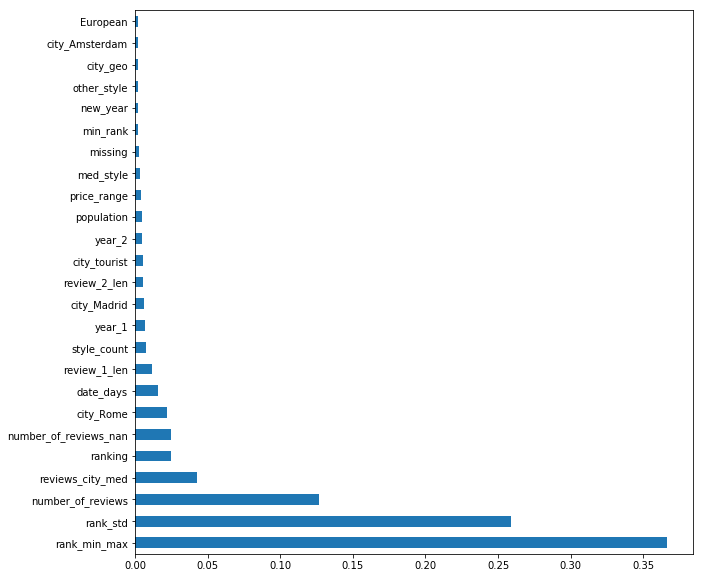

In [126]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [127]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,Rating,missing,number_of_reviews_nan,cuisine_style_nan,price_range_nan,rewiews_nan,max_rank,...,city_Vienna,city_Warsaw,city_Zurich,city_nan,review_1_len,review_2_len,new_year,year_1,year_2,date_days
9435,2295.0,0,3.0,0.0,1,0,0,1,0,4188.0,...,0,0,0,0,0.0,0.0,0,2015.0,2015.0,132.0
4113,2342.0,2,39.0,0.0,0,0,0,0,0,2666.0,...,0,0,0,0,15.0,0.0,1,2015.0,0.0,3.0
3544,2350.0,1,17.0,0.0,0,0,0,0,0,3444.0,...,1,0,0,0,10.0,11.0,0,2017.0,2017.0,246.0
920,1948.0,1,10.0,0.0,0,0,0,0,0,3254.0,...,0,0,0,0,8.0,0.0,0,2017.0,2016.0,340.0
2298,2811.0,2,15.0,0.0,0,0,0,0,0,3254.0,...,0,0,0,0,9.0,0.0,0,2017.0,2017.0,39.0
3405,488.0,2,257.0,0.0,0,0,0,0,0,3717.0,...,0,0,0,0,20.0,0.0,0,2018.0,2017.0,94.0
78,10604.0,1,9.0,0.0,0,0,0,0,0,13986.0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,3.0
2252,6953.0,0,17.0,0.0,2,0,1,1,0,8809.0,...,0,0,0,0,36.0,26.0,0,2017.0,2016.0,101.0
5221,6774.0,0,46.0,0.0,2,0,1,1,0,8809.0,...,0,0,0,0,27.0,34.0,0,2017.0,2017.0,58.0
3102,107.0,3,878.0,0.0,0,0,0,0,0,7796.0,...,0,0,0,0,11.0,0.0,1,2018.0,2018.0,6.0


In [128]:
test_data = test_data.drop(['Rating'], axis=1)

In [129]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [130]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [131]:
predict_submission

array([3.095, 4.2  , 4.525, ..., 3.135, 4.475, 4.205])

In [132]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.095
1,id_1,4.200
2,id_2,4.525
3,id_3,4.350
4,id_4,4.460
5,id_5,4.440
6,id_6,1.680
7,id_7,3.140
8,id_8,4.130
9,id_9,4.655


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
